## Imports

In [4]:
import re
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.style.use('seaborn')

# !!! The next cell should be executed only once and in before any cell below it is executed !!!

In [5]:
results_dir = os.path.abspath('.')

# Preliminaries

## Get the variation parameters

In [50]:
os.chdir(results_dir)
experiment = 'E_Coli_ART_Illumina'
os.chdir(experiment)

counts_files_re = re.compile(r'K(\d+)W(\d+)D(\d+)T(\d+).counts')
counts_files = [filename for filename in os.listdir() if counts_files_re.match(filename)]

Ks = set()
Ws = set()
Ds = set()
Ts = set()
for filename in counts_files:
    matches = counts_files_re.match(filename)
    Ks.add(int(matches.group(1)))
    Ws.add(int(matches.group(2)))
    Ds.add(int(matches.group(3)))
    Ts.add(int(matches.group(4)))

print(f'{Ks = }; {Ws = }; {Ds = }; {Ts = }')

Ks = {31}; Ws = {17500000, 12500000, 5000000, 7500000, 15000000, 10000000, 20000000}; Ds = {8}; Ts = {40}


## Get the k-mers from the sequence

In [58]:
sequence_kmers = {}
with open('../../data/E_Coli/chromosomal_dna.fa') as sequence_file:
    sequence = ''.join(sequence_file.readlines()[1:]).replace('\n', '')
    for K in Ks:
        sequence_kmers[K] = set()
        for i in range(len(sequence) - K + 1):
            sequence_kmers[K].add(sequence[i:i+K])

# Single experiment analysis

## Experiment Parameters

In [55]:
K = 31
W = 20000000
D = 8
T = 40

## Get the count results

The count results are obtained from the file 'K<K>W<W>D<D>T<T>.counts' where they are written as a `csv` in the form `k-mer, exact_count, estimated_count`.

In [56]:
exact_counts_log = {}
estimated_counts_log = {}
errors = []
distinct_kmer_count = 0
with open(f'K{K}W{W}D{D}T{T}.counts') as counts_file:
    for line in counts_file:
        _, exact_count, estimated_count = line.strip().split(',')
        exact_count_log = np.floor(np.log2(int(exact_count)))
        estimated_count_log = np.floor(np.log2(int(estimated_count)))
        
        if exact_count_log not in exact_counts_log:
            exact_counts_log[exact_count_log] = 0
        exact_counts_log[exact_count_log] += 1
        
        if estimated_count_log not in estimated_counts_log:
            estimated_counts_log[estimated_count_log] = 0
        estimated_counts_log[estimated_count_log] += 1
        
        errors.append(int(estimated_count) - int(exact_count))
        
        distinct_kmer_count += 1
errors = np.array(errors)

## Plot k-mer count frequencies

### Exact

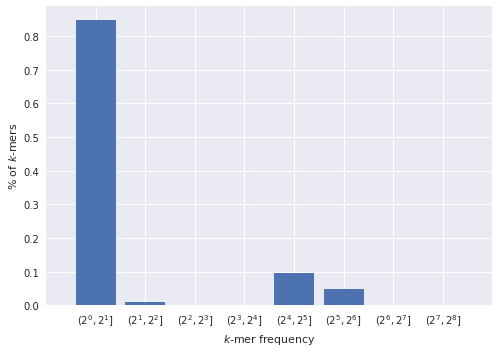

In [24]:
x = list(exact_counts_log.keys())
y = list(frequency / distinct_kmer_count for frequency in exact_counts_log.values())
plt.bar(x, y)
plt.xlabel('$k$-mer frequency')
plt.ylabel('% of $k$-mers')
plt.xticks(x[:8], [f'$(2^{{{int(i)}}},2^{{{int(i+1)}}}]$' for i in x[:8]])
plt.xlim(-1,8)
plt.show()

### Estimated

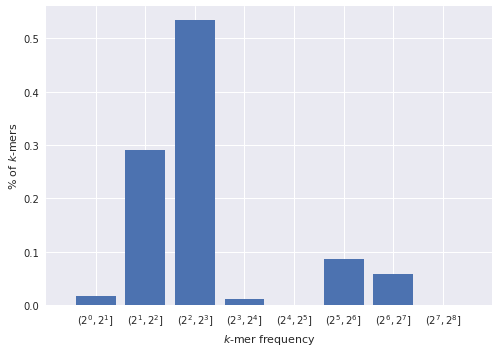

In [87]:
x = list(estimated_counts_log.keys())
y = list(frequency / distinct_kmer_count for frequency in estimated_counts_log.values())
plt.bar(x, y)
plt.xlabel('$k$-mer frequency')
plt.ylabel('% of $k$-mers')
plt.xticks([i for i in range(int(max(x[:7]))+1)], [f'$(2^{{{int(i)}}},2^{{{int(i+1)}}}]$' for i in range(int(max(x[:7])) + 1)])
plt.xlim(-1,8)
plt.show()

## Calculate errors and error statistics

The error is defined as `estimated_count - exact_count`. Since the Count-min sketch will always overestimate the count, the error is always a positive number. As such, we can genrate a mean error and the standard deviation of the errors.These two values are printed as a result of the cell execution.

In [49]:
print(f'Mean Error: {np.mean(errors)}; Std Dev: {np.std(errors)}')

Mean Error: 8.154347492746284; Std Dev: 11.582510207266678


## Threshold Evaluation

Based on the k-mer counts, both exact and count-min estimate, see how many k-mers would be considered present in the graph for different values of the presence threshold (going up in steps of 10 up to 2 * coverage). The ideal threshold minimizes the number of false k-mers detected while maximizing the number of true k-mers (effectively reducing false positive and negative rates). However, the bigger the threshold, the better from a theoretical perspective to reduce sketch size by reducing `W`.

In [73]:
thresholds = [max(1, threshold) for threshold in range(0, 80*2, 10)]
kmers_detected = {
    'true': {
        'exact': {threshold: 0 for threshold in thresholds},
        'estimate': {threshold: 0 for threshold in thresholds}
    },
    'false': {
        'exact': {threshold: 0 for threshold in thresholds},
        'estimate': {threshold: 0 for threshold in thresholds}
    }
}
false_kmer_count = 0
with open(f'K{K}W{W}D{D}T{T}.counts') as counts_file:
    for line in counts_file:
        kmer, exact_count, estimated_count = line.strip().split(',')
        exact_count = int(exact_count)
        estimated_count = int(estimated_count)
        
        if kmer in sequence_kmers[K]:
            for threshold in thresholds:
                kmers_detected['true']['exact'][threshold] += 1 if exact_count >= threshold else 0
                kmers_detected['true']['estimate'][threshold] += 1 if estimated_count >= threshold else 0
        else:
            false_kmer_count += 1
            for threshold in thresholds:
                kmers_detected['false']['exact'][threshold] += 1 if exact_count >= threshold else 0
                kmers_detected['false']['estimate'][threshold] += 1 if estimated_count >= threshold else 0            

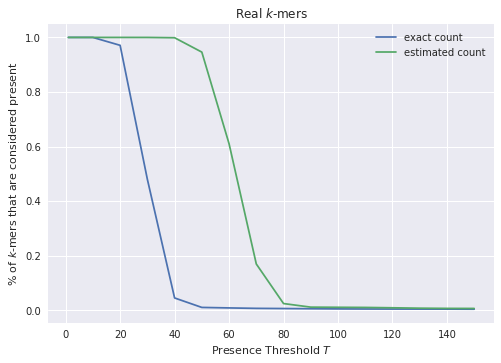

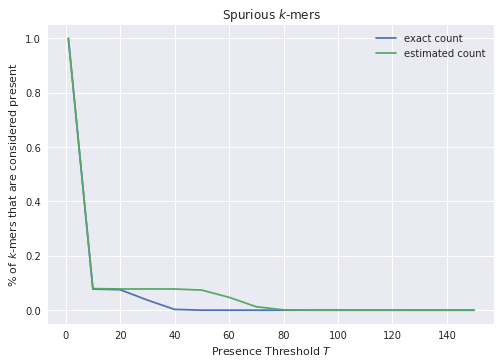

In [80]:
plt.plot(list(kmers_detected['true']['exact'].keys()), list(count / len(sequence_kmers[K]) for count in kmers_detected['true']['exact'].values()), label='exact count')
plt.plot(list(kmers_detected['true']['estimate'].keys()), list(count / len(sequence_kmers[K]) for count in kmers_detected['true']['estimate'].values()), label='estimated count')
plt.xlabel('Presence Threshold $T$')
plt.ylabel('% of $k$-mers that are considered present')
plt.title('Real $k$-mers')
plt.legend()
plt.show()
plt.plot(list(kmers_detected['false']['exact'].keys()), list(count / false_kmer_count for count in kmers_detected['false']['exact'].values()), label='exact count')
plt.plot(list(kmers_detected['false']['estimate'].keys()), list(count / false_kmer_count for count in kmers_detected['false']['estimate'].values()), label='estimated count')
plt.xlabel('Presence Threshold $T$')
plt.ylabel('% of $k$-mers that are considered present')
plt.title('Spurious $k$-mers')
plt.legend()
plt.show()

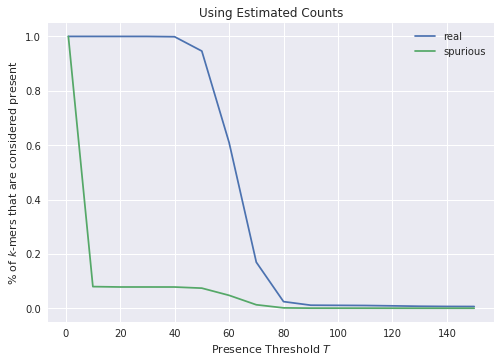

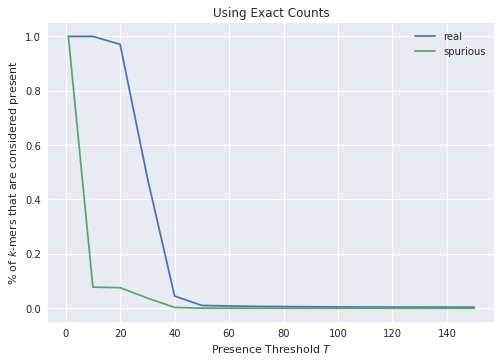

In [79]:
plt.plot(list(kmers_detected['true']['estimate'].keys()), list(count / len(sequence_kmers[K]) for count in kmers_detected['true']['estimate'].values()), label='real')
plt.plot(list(kmers_detected['false']['estimate'].keys()), list(count / false_kmer_count for count in kmers_detected['false']['estimate'].values()), label='spurious')
plt.xlabel('Presence Threshold $T$')
plt.ylabel('% of $k$-mers that are considered present')
plt.title('Using Estimated Counts')
plt.legend()
plt.show()

plt.plot(list(kmers_detected['true']['exact'].keys()), list(count / len(sequence_kmers[K]) for count in kmers_detected['true']['exact'].values()), label='real')
plt.plot(list(kmers_detected['false']['exact'].keys()), list(count / false_kmer_count for count in kmers_detected['false']['exact'].values()), label='spurious')
plt.xlabel('Presence Threshold $T$')
plt.ylabel('% of $k$-mers that are considered present')
plt.title('Using Exact Counts')
plt.legend()
plt.show()

# W Variation analysis

In [51]:
K = 31
D = 8
T = 40

In [52]:
results = []
for W in Ws:
    print(W, end='\r')
    errors = []
    with open(f'K{K}W{W}D{D}T{T}.counts') as counts_file:
        for line in counts_file:
            _, exact_count, estimated_count = line.strip().split(',')

            errors.append(int(estimated_count) - int(exact_count))
    errors = np.array(errors)
    results.append({
        'K': K,
        'W': W,
        'D': D,
        'T': T,
        'mean_error': np.mean(errors),
        'error_stddev': np.std(errors)
    })
results_df = pd.DataFrame(results)

<AxesSubplot:xlabel='W'>

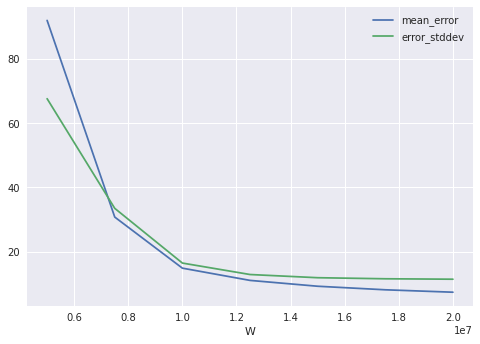

In [54]:
results_df.sort_values('W').plot('W', ['mean_error', 'error_stddev'])